# 10번
### 올리베티 흑백얼굴 이미지

In [ ]:
# 파이썬 ≥3.5 필수
import sys



assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces(shuffle=True)
print(olivetti.DESCR)

In [ ]:
olivetti.target

In [ ]:
# 데이터 나누기
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(olivetti.data,olivetti.target,test_size= 40, random_state=42 )
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 80, random_state=42 )

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
## 속도를 높히기 위해 차원 축고
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

k값을 5~ 150 까지 5단위로 변경해가며 KMenas 훈련시키고 리스트에 담는다.
그 후 실루엣 점수를 비교하여 최선의 k값을 찾는다.

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

In [ ]:
# 실루엣 점수 plot으로 확인하기.
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [ ]:
# 이니셔 그리기
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

In [ ]:
best_model = kmeans_per_k[best_index]

def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

# 11번

In [ ]:
# 분류기를 훈련하고 검증세트에 평가
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_val)

In [ ]:
# 위의 최선의 K값 가진 것으로 차원 축소하고 펴가.
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)

clf.score(X_valid_reduced, y_val)

In [ ]:
# 파이프라인을 통해 k 값별 훈련
from sklearn.pipeline import Pipeline
for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_val))

In [ ]:
# 축소된 차원의 특성을 원본 특성에 추가함
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [ ]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_val)

# 12. gaussian

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

 모델을 사용해 (sample() 메서드로) 새로운 얼굴을 생성하고 시각화해보세요(PCA를 사용했다면 inverse_transform() 메서드를 사용해야 합니다).

In [ ]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

In [ ]:
plot_faces(gen_faces, y_gen_faces)

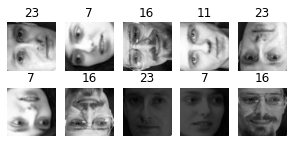

In [25]:
# 회전
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]
# 뒤집기
n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]
# 어둡게 하기
n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [26]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [27]:
gm.score_samples(X_bad_faces_pca)

array([-5.65863290e+07, -3.68346160e+07, -3.50815822e+07, -5.32639926e+07,
       -2.06893517e+07, -3.05945582e+07, -5.43266670e+07, -1.12348727e+08,
       -1.12047308e+08, -1.06698204e+08])

In [28]:
gm.score_samples(X_train_pca[:10])


array([1130.52492888, 1181.65775691, 1137.35723278, 1159.28597155,
       1160.42459614, 1060.1634796 , 1067.92088453, 1060.16350728,
       1182.70744968, 1151.08277127])

차원 축소 기법을 통해 이상치 탐지를 위해서 사용할 수 도 있다.



In [ ]:
'''
처음에 했던 것 그대로 사용한다.
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_
'''


In [30]:
# 재구성 오차를 리턴하는 함수
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [31]:
reconstruction_errors(pca, X_train).mean()


0.00018911969

In [32]:
reconstruction_errors(pca, X_bad_faces).mean()


0.0049947286

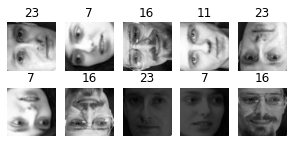

In [33]:
plot_faces(X_bad_faces, y_bad)


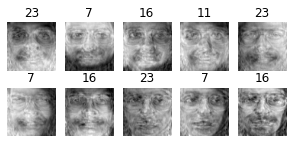

In [34]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)
